# Quality control

Here I want to check the data for any weird spikes and 
1. in th EB dataset: for the diving event 2016/2017 cut out the data from 100m and set to 250m and then replace the 100m values with nans
2. cut out weird spike in WB1 dataset 
3. WB datasets: create a 3rd dimension in both datasets
4. concat along a 3rd dimension and use mean of both datasets where 2 values exist

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
file_name = "data/rteb1_all_merged.nc"
ds_eb = xr.open_dataset(file_name)

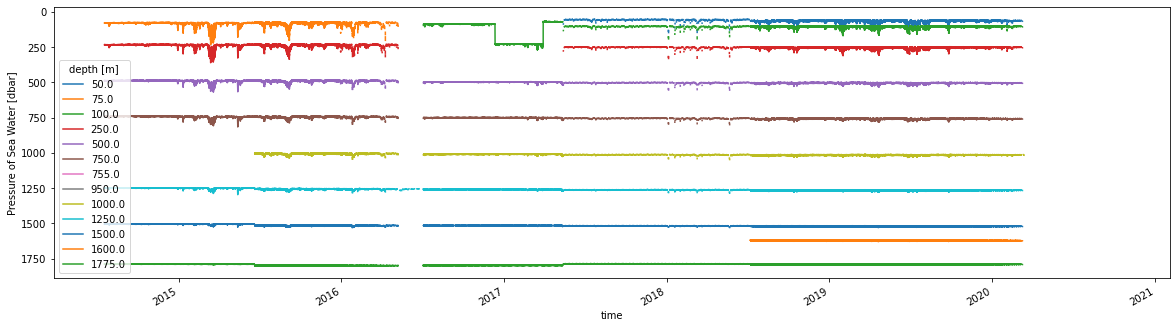

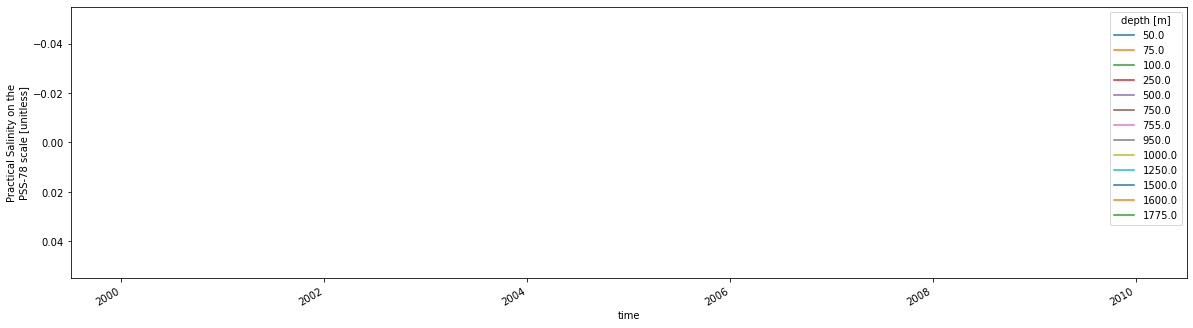

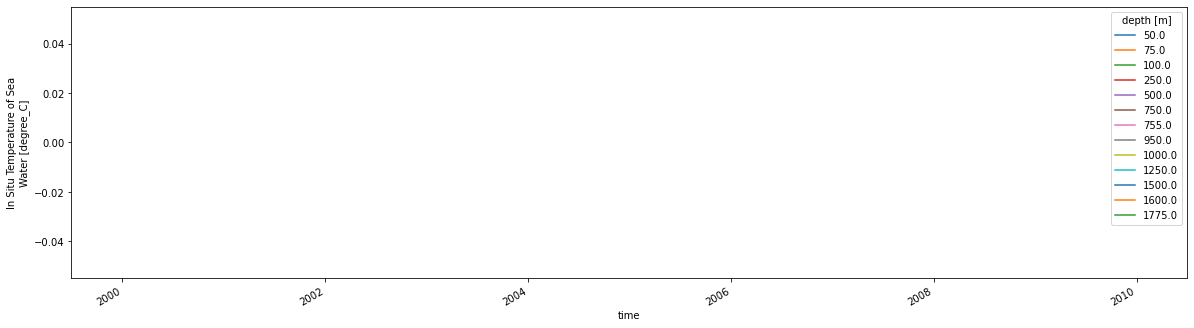

In [44]:
ds_eb.pres.where(ds_eb.pres>0).plot.line(x='time', figsize = (20,5), yincrease = False); #.where(ds.pres>0);
ds_eb.sal.where(ds_eb.sal<0).plot.line(x='time', figsize = (20,5), yincrease = False);
ds_eb.temp.where(ds_eb.temp>15).plot.line(x='time', figsize = (20,5));

# seems fine, just need to fix 2017

In [45]:
ds_eb75=ds_eb.sel(depth=75) 
ds_eb950=ds_eb.sel(depth=950)
ds_eb755=ds_eb.sel(depth=755)
ds_eb1000=ds_eb.sel(depth=1000) 
ds_eb1600=ds_eb.sel(depth=1600) 


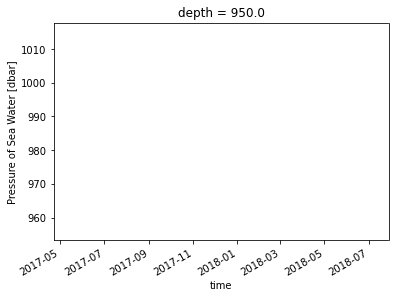

In [46]:
# I can probably just drop the variable completely then
ds_eb950.pres.plot.line(x='time')

In [47]:
eb_dive = ds_eb.sel(depth=100).where(ds_eb.pres.sel(depth=100)>220) #, time = slice('2016-10-1', '2017-4-30')

#eb_dive.pres.plot.line(x='time', yincrease = False)

In [48]:
eb_dive.update({'depth':('depth', [250])});

In [49]:
ds_eb=ds_eb.fillna(value=eb_dive)

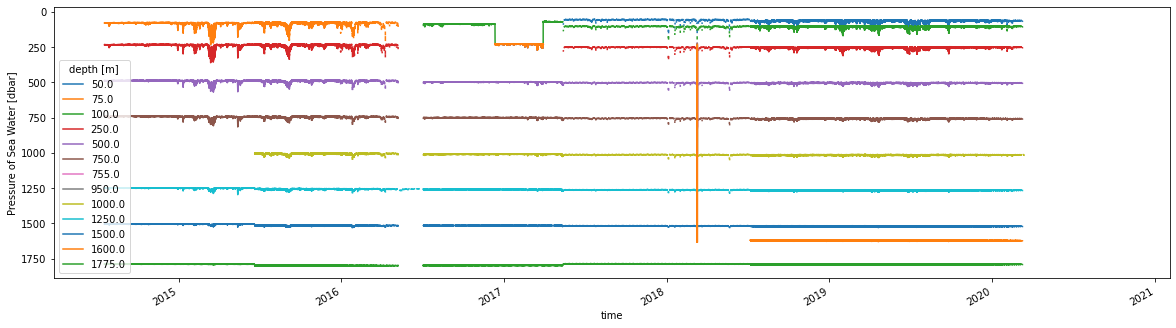

In [50]:
ds_eb.pres.plot.line(x='time', figsize = (20,5), yincrease = False);

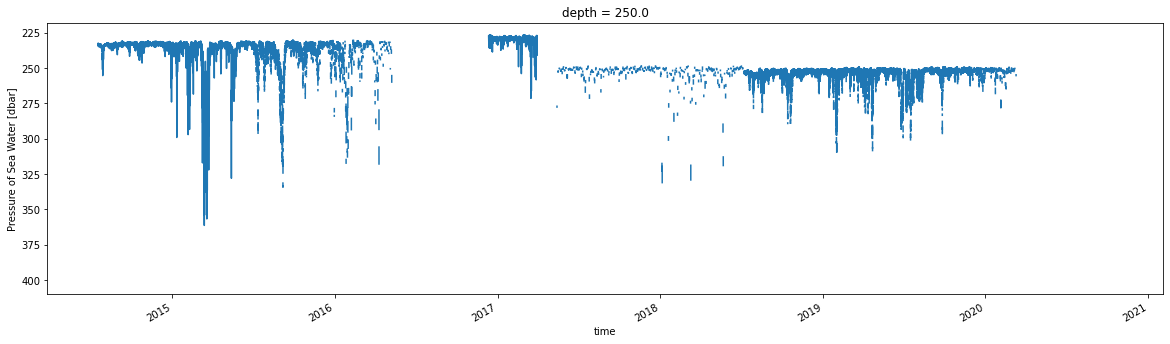

In [51]:
ds_eb.pres.sel(depth=250).plot.line(x='time', figsize = (20,5), yincrease = False);
# this looks good

In [52]:
ds_eb250=ds_eb.sel(depth=250)

In [53]:
ds_eb=ds_eb.drop_sel(depth=[75])
ds_eb=ds_eb.drop_sel(depth=[250])
ds_eb=ds_eb.drop_sel(depth=[755])
ds_eb=ds_eb.drop_sel(depth=[950])
ds_eb=ds_eb.drop_sel(depth=[1000])
ds_eb=ds_eb.drop_sel(depth=[1600])

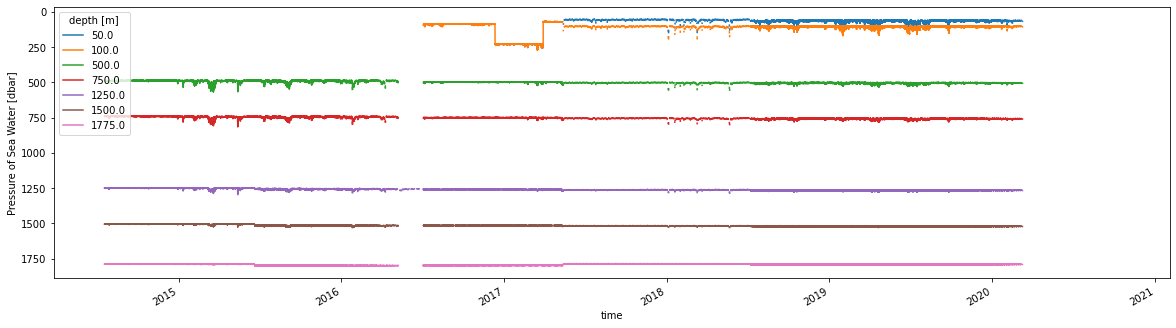

In [54]:
ds_eb.pres.plot.line(x='time', figsize = (20,5), yincrease = False);

In [ ]:
## 100m data
- removing the pressure during the diving event
- removing the spike in the temperature...

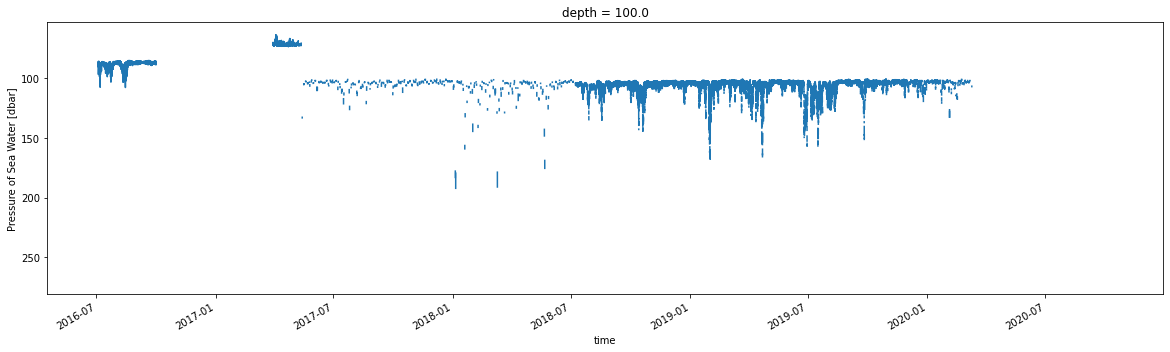

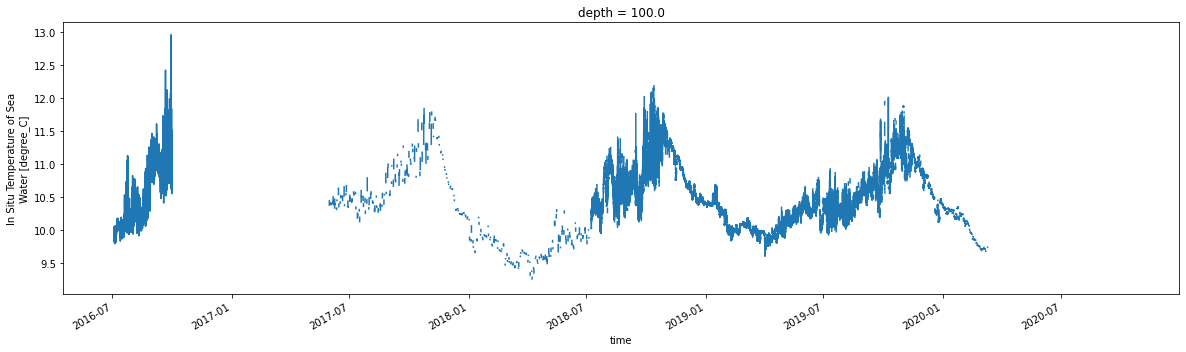

In [55]:
ds_eb100 = ds_eb.sel(depth=100).where(((ds_eb.time<np.datetime64('2016-10-01')) | (ds_eb.time>np.datetime64('2017-03-30'))))
ds_eb100t = ds_eb100.temp.where(((ds_eb.time<np.datetime64('2017-03-30')) | (ds_eb.time>np.datetime64('2017-05-31'))))
ds_eb100.pres.plot.line(x='time',figsize = (20,5),yincrease=False);
ds_eb100t.plot.line(x='time',figsize = (20,5));
# that is what I want now I just need to put it into the ds_eb instead of the data already there

In [56]:
ds_eb100 = ds_eb100.drop_vars('temp')

In [57]:
ds_eb100

<xarray.Dataset>
Dimensions:  (time: 218388)
Coordinates:
    depth    float64 100.0
  * time     (time) datetime64[ns] 2014-07-18T12:30:01.008000 ... 2020-10-12T...
Data variables:
    pres     (time) float64 nan nan nan nan nan nan ... 101.9 nan 102.1 nan nan
    sal      (time) float64 nan nan nan nan nan nan ... 35.37 nan 35.38 nan nan
Attributes:
    Mooring:          rteb1
    WaterDepth:       1800
    Start_Date:       2014/07/18
    Start_Time:       12:30
    End_Date:         2015/06/20
    End_Time:         06:30
    Latitude:         57.099333333333334
    Longitude:        -9.548
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

In [59]:
ds_eb100 = xr.merge([ds_eb100,ds_eb100t])

In [60]:
ds_eb = ds_eb.drop_sel(depth=[100])

In [61]:
ds_eb = xr.concat([ds_eb, ds_eb75, ds_eb100, ds_eb250, ds_eb755, ds_eb950, ds_eb1000, ds_eb1600], dim='depth')

In [62]:
ds_eb = ds_eb.sortby(ds_eb.depth)

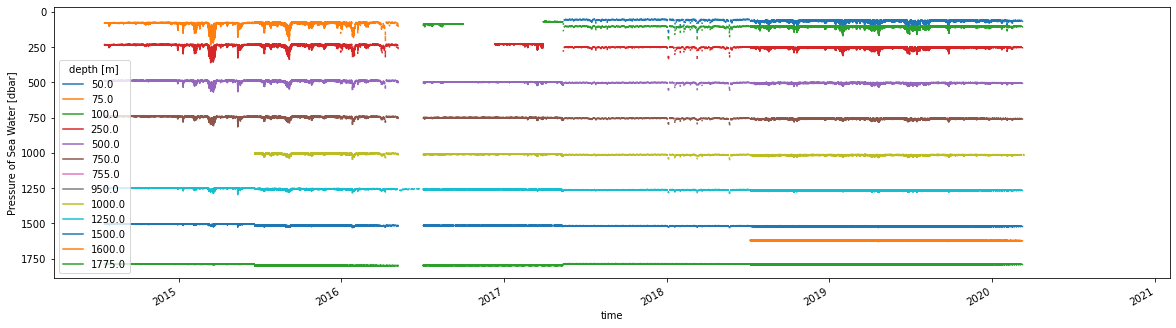

In [63]:
ds_eb.pres.plot.line(x='time', figsize = (20,5), yincrease = False);

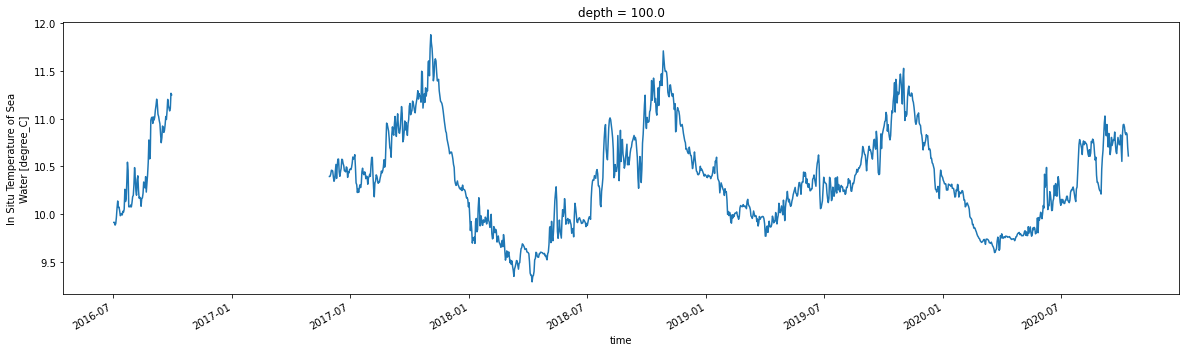

In [67]:
## checking that 100m temperature no longer has weird spike
ds_eb.temp.sel(depth = 100).plot.line(x='time', figsize = (20,5));

In [64]:
ds_eb = ds_eb.resample(time = "1D").mean(keep_attrs=True);

<xarray.Dataset>
Dimensions:  (depth: 13, time: 2279)
Coordinates:
  * time     (time) datetime64[ns] 2014-07-18 2014-07-19 ... 2020-10-12
  * depth    (depth) float64 50.0 75.0 100.0 250.0 ... 1.5e+03 1.6e+03 1.775e+03
Data variables:
    temp     (time, depth) float64 nan 10.47 nan 9.887 ... 4.422 4.098 3.748
    pres     (time, depth) float64 nan 78.23 nan ... 1.623e+03 1.79e+03
    sal      (time, depth) float64 nan 35.39 nan 35.39 ... 34.98 34.95 34.94
Attributes:
    Mooring:          rteb1
    WaterDepth:       1800
    Start_Date:       2014/07/18
    Start_Time:       12:30
    End_Date:         2015/06/20
    End_Time:         06:30
    Latitude:         57.099333333333334
    Longitude:        -9.548
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

In [68]:
ds_eb.to_netcdf('data/rteb_qc_1D.nc', 
        engine='netcdf4',
        encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})